In [6]:
import tensorflow as tf
import numpy as np
%matplotlib inline  
import matplotlib.pyplot as plt

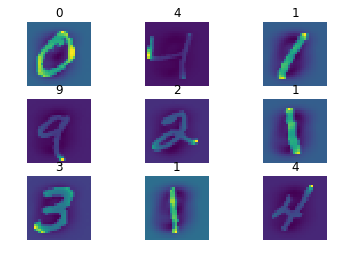

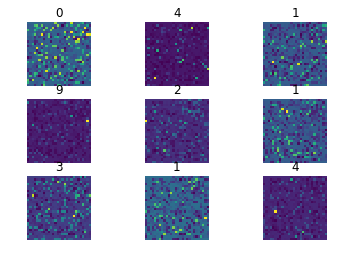

In [48]:
#1),3),5),8) It is the latest version with the class

class CNN:
    
    def __init__(self, Xdata_path, Ydata_path, learning_rate_1, epochs, batch):
        
        self.Xdata = np.load(Xdata_path)
        self.Ydata = np.load(Ydata_path)
        self.learning_rate_1 = learning_rate_1
        self.epochs = epochs
        self.batch = batch
        
        self.n = 50000
        self.Xtrn, self.Ytrn = (self.Xdata[:self.n]-np.mean(self.Xdata[:self.n]))/np.std(self.Xdata[:self.n]),np.squeeze(self.Ydata[:self.n])
        n, self.inp_dims = self.Xtrn.shape
        self.Xval,self.Yval = (self.Xdata[self.n:]-np.mean(self.Xdata[self.n:]))/np.std(self.Xdata[self.n:]),np.squeeze(self.Ydata[self.n:]) 

        
        Xdata_2d = np.concatenate((np.zeros([self.Xdata.shape[0],10]),self.Xdata,np.zeros([self.Xdata.shape[0],6])),axis=1).reshape((self.Xdata.shape[0],28,28))
        self.X_2d_trn = Xdata_2d[:self.n]
        self.X_2d_val = Xdata_2d[self.n:]
        
        perms = np.random.permutation(768)
        XdataP = self.Xdata[:,perms]
        XdataP_2d = np.concatenate((np.zeros([self.Xdata.shape[0],10]),XdataP,np.zeros([self.Xdata.shape[0],6])),axis=1).reshape((self.Xdata.shape[0],28,28))
        self.XP_2d_trn = XdataP_2d[:self.n]
        self.XP_2d_val = XdataP_2d[self.n:]
    
    def cnn(self,X, y, k, l, learning_rate, prob, cnn_dims = 2):

        X = tf.expand_dims(X,-1)

        for i in range(k):        
            X = tf.layers.conv2d(X, 32 , 5 , padding='same', activation = tf.nn.relu) if (cnn_dims == 2) else tf.layers.conv1d(X, 32 , 5 , activation = tf.nn.relu) 
            X = tf.layers.max_pooling2d(X, 3, 2, padding='same') if (cnn_dims == 2) else tf.layers.max_pooling1d(X, 3, 2)

        X = tf.nn.dropout(X, keep_prob = prob)
        X = tf.layers.flatten(X)

        for i in range(l):
            X = tf.layers.dense(X, 100, activation = tf.nn.relu)
            X = tf.nn.dropout(X, keep_prob = prob)

        logits = tf.layers.dense(X, 10, activation = None)
        softmax_ = tf.nn.softmax(logits)

        xentropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(y,10, dtype=tf.float32), logits=logits))
        train_step = tf.train.AdamOptimizer(learning_rate).minimize(xentropy)
        correct_prediction = tf.equal(tf.argmax(softmax_, 1), tf.cast(y, tf.int64))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        return xentropy, accuracy, train_step, softmax_
    
    def stoch(self, k ,l , Xtrn = None, Xval = None, Ytrn = None, Yval = None, batch = None, epochs = None, learning_rate = None, momentum = 0.0, only_last = False, optimizer = "None", cnn_dims = 2, test = None):
        
        if Xtrn is None:
            Xtrn = self.X_2d_trn if (cnn_dims == 2)  else self.Xtrn
        if Xval is None:
            Xval = self.X_2d_val if (cnn_dims == 2) else self.Xval
        if batch is None:
            batch = self.batch
        if epochs is None:
            epochs = self.epochs
        if learning_rate is None:
            learning_rate = self.learning_rate_1
        if Ytrn is None:
            Ytrn = self.Ytrn
        if Yval is None:
            Yval = self.Yval
        
        print("k =",k, "l =",l,"batch =",batch,"learning_rate =",learning_rate,"momentum = ", momentum)
        tf.reset_default_graph()

        X = tf.placeholder(tf.float32, shape=(None, 28, 28), name="X") if (cnn_dims == 2) else tf.placeholder(tf.float32, shape=(None, self.inp_dims), name="X")
        y = tf.placeholder(tf.int32, shape=(None), name="y")
        p = tf.placeholder(tf.float32)

        
        loss, acc, up, softmax = self.cnn(X, y, k, l, learning_rate, p, cnn_dims)
        
        perms = np.array_split(np.random.permutation(len(Xtrn)),len(Xtrn)/batch)
        init = tf.global_variables_initializer()


        with tf.Session() as sess:
            sess.run(init)
            for i in range(epochs):
                for perm in perms:
                    if optimizer not in ["adam","gradient"]:
                        loss_train, acc_train, _, _, _ = sess.run([loss,acc,up[0],up[1],up[2]], feed_dict={X: Xtrn[perm], y:Ytrn[perm], p: 0.7})
                    else:
                        loss_train, acc_train, _ = sess.run([loss,acc,up], feed_dict={X: Xtrn[perm], y:Ytrn[perm], p: 0.7})
                loss_val, acc_val = sess.run([loss, acc], feed_dict={X: Xval, y:Yval, p: 1.0})
                if only_last == False:
                    print("step", i, "loss(train)", loss_train, "loss(val)", loss_val, "accuracy(train)", acc_train, "accuracy(val)", acc_val)
            if only_last == True:
                print("step", i, "loss(train)", loss_train, "loss(val)", loss_val, "accuracy(train)", acc_train, "accuracy(val)", acc_val)
            if test is not None:
                return sess.run(softmax, feed_dict={X: test, y: Yval, p: 1.0})
    def show_n(self, n,img_data):
        for i in range(1,n):
            plt.subplot(330+i)
            plt.imshow(img_data[i,:,:])
            plt.title(self.Ytrn[i])
            plt.axis('off')
        plt.show()
if __name__ == '__main__':
    cnn1 = CNN("../data/hw2-train-data.npy","../data/hw2-train-labels.npy",0.001,10,25)
    cnn1.show_n(10,cnn1.X_2d_trn)
    cnn1.show_n(10,cnn1.XP_2d_trn)


In [51]:
Xtst = np.load("../data/hw2-test-data.npy")
yTst = cnn1.stoch(epochs = 40, k = 4, l = 1, optimizer = "adam", test = np.concatenate((np.zeros([Xtst.shape[0],10]),Xtst,np.zeros([Xtst.shape[0],6])),axis=1).reshape((Xtst.shape[0],28,28)))
yTst = np.argmax(yTst,axis=1)
np.savetxt('../data/hw3-test-labels.txt',yTst,fmt='%d')

('k =', 4, 'l =', 1, 'batch =', 25, 'learning_rate =', 0.001, 'momentum = ', 0.0)
('step', 0, 'loss(train)', 0.08501377, 'loss(val)', 0.076849423, 'accuracy(train)', 0.95999998, 'accuracy(val)', 0.97626668)
('step', 1, 'loss(train)', 0.071492232, 'loss(val)', 0.056528043, 'accuracy(train)', 0.95999998, 'accuracy(val)', 0.98320001)
('step', 2, 'loss(train)', 0.13606073, 'loss(val)', 0.055904336, 'accuracy(train)', 0.92000002, 'accuracy(val)', 0.98439997)
('step', 3, 'loss(train)', 0.033105291, 'loss(val)', 0.04698693, 'accuracy(train)', 1.0, 'accuracy(val)', 0.98573333)
('step', 4, 'loss(train)', 0.048371404, 'loss(val)', 0.056089353, 'accuracy(train)', 1.0, 'accuracy(val)', 0.98439997)
('step', 5, 'loss(train)', 0.0069371467, 'loss(val)', 0.047289141, 'accuracy(train)', 1.0, 'accuracy(val)', 0.98839998)
('step', 6, 'loss(train)', 0.0017012982, 'loss(val)', 0.051519021, 'accuracy(train)', 1.0, 'accuracy(val)', 0.98813331)
('step', 7, 'loss(train)', 0.0011330786, 'loss(val)', 0.049020704